# **Importing Libraries**

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
%matplotlib inline

In [3]:
warnings.filterwarnings('ignore')

The next cell will install kaggle which soon will allow us to download the dataset

In [4]:
!pip install kaggle

In the following cell, upload the kaggle.json API file which will let us download the dataset

In [5]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"geraygench","key":"044426052610aea6df5ef6aaaa85b3ce"}'}

In [6]:
! mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle competitions download -c commonlit-evaluate-student-summaries

 95% 1.00M/1.05M [00:00<00:00, 1.52MB/s]
100% 1.05M/1.05M [00:00<00:00, 1.58MB/s]


In [8]:
import zipfile
import os

# Specify the path to the zip archive
zip_file_path = 'commonlit-evaluate-student-summaries.zip'

# Specify the directory where you want to extract the files
extract_dir = 'commonlit_evaluate_student_summaries'

# Create the extract directory if it doesn't exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Open the zip archive
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents to the specified directory
    zip_ref.extractall(extract_dir)

print("Zip archive extracted to", extract_dir)

Zip archive extracted to commonlit_evaluate_student_summaries


## Dataset Description

The dataset comprises about 24,000 summaries written by students in grades 3-12 of passages on a variety of topics and genres. These summaries have been assigned scores for both content and wording.

### File and Field Information

* summaries_train.csv - Summaries in the training set.
 * student_id - The ID of the student writer.
 * prompt_id - The ID of the prompt which links to the prompt file.
 * text - The full text of the student's summary.
 * content - The content score for the summary. The first target.
 * wording - The wording score for the summary. The second target.
* summaries_test.csv - Summaries in the test set. Contains all fields above except content and wording.
* prompts_train.csv - The four training set prompts. Each prompt comprises the complete summarization assignment given to students.
 * prompt_id - The ID of the prompt which links to the summaries file.
 * prompt_question - The specific question the students are asked to respond to.
 * prompt_title - A short-hand title for the prompt.
 * prompt_text - The full prompt text.
* prompts_test.csv - The test set prompts. Contains the same fields as above. The prompts here are only an example. The full test set has a large number of prompts. The train / public test / private test splits do not share any prompts.
*sample_submission.csv - A submission file in the correct format

In [9]:
# This is how a sample submission looks
df_samplesub=pd.read_csv("commonlit_evaluate_student_summaries/sample_submission.csv")
df_samplesub.head()

,student_id,content,wording
0,000000ffffff,0.0,0.0
1,111111eeeeee,0.0,0.0
2,222222cccccc,0.0,0.0
3,333333dddddd,0.0,0.0


In [10]:
df_train_summ=pd.read_csv("commonlit_evaluate_student_summaries/summaries_train.csv")
print("Shape of df_train_text: ",df_train_summ.shape)
df_train_summ.head()

Shape of df_train_text:  (7165, 5)


,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


In [11]:
df_train_summ.describe()

,content,wording
count,7165.000000,7165.000000
mean,-0.014853,-0.063072
std,1.043569,1.036048
min,-1.729859,-1.962614
25%,-0.799545,-0.872720
50%,-0.093814,-0.081769
75%,0.499660,0.503833
max,3.900326,4.310693


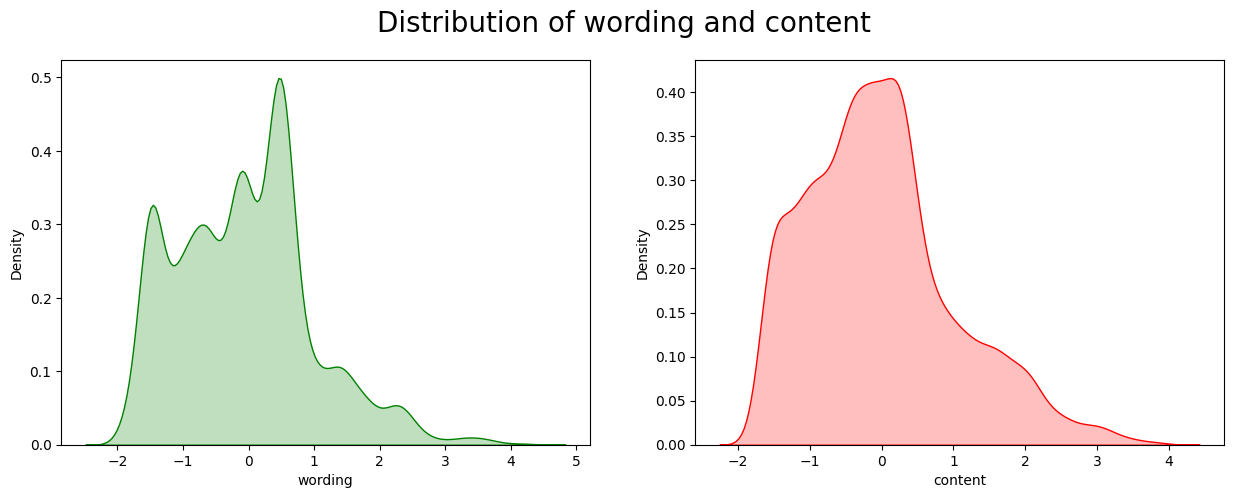

In [12]:
fig, ax =plt.subplots(1,2)
fig.set_size_inches(15,5)
fig.suptitle("Distribution of wording and content", fontsize=20)
sns.kdeplot(df_train_summ['wording'], shade=True, ax=ax[0], color='green')
sns.kdeplot(df_train_summ['content'], shade=True, ax=ax[1], color='red')
fig.show()


In [13]:
df_train_prompts=pd.read_csv("commonlit_evaluate_student_summaries/prompts_train.csv")
print("Shape of df_test_p: ",df_train_prompts.shape)
df_train_prompts.head(1)

Shape of df_test_p:  (4, 4)


,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...


In [14]:
df_test_summ=pd.read_csv("commonlit_evaluate_student_summaries/summaries_test.csv")
print("Shape of df_test_text: ",df_test_summ.shape)
df_test_summ.head()

Shape of df_test_text:  (4, 3)


,student_id,prompt_id,text
0,000000ffffff,abc123,Example text 1
1,111111eeeeee,def789,Example text 2
2,222222cccccc,abc123,Example text 3
3,333333dddddd,def789,Example text 4


In [15]:
df_test_prompts=pd.read_csv("commonlit_evaluate_student_summaries/prompts_test.csv")
print("Shape of df_test_p: ",df_test_prompts.shape)
df_test_prompts.head()

Shape of df_test_p:  (2, 4)


,prompt_id,prompt_question,prompt_title,prompt_text
0,abc123,Summarize...,Example Title 1,Heading\nText...
1,def789,Summarize...,Example Title 2,Heading\nText...


In [16]:
! pip install ydata-profiling


Lets have a look at the dataset with the help of Profiling Report which tells us a lot about our dataset its structure and data type of each column




In [17]:
from ydata_profiling import ProfileReport

In [18]:
profile = ProfileReport(df_train_summ, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

([<matplotlib.patches.Wedge at 0x7c7518d527a0>,
 [Text(0.7441258598778328, 0.9414227024355617, '39c16e'),
  Text(-0.9871770139847208, 0.4852644053093227, '3b9047'),
  Text(-0.2951302904781698, -1.0596688688653033, 'ebad26'),
  Text(0.9738464548017034, -0.511491038504248, '814d6b')],
 [Text(0.434073418262069, 0.5491632430874109, '28.7%'),
  Text(-0.5384601894462113, 0.2646896756232669, '28.0%'),
  Text(-0.16098015844263805, -0.5780012011992562, '27.9%'),
  Text(0.5311889753463837, -0.27899511191140797, '15.4%')])

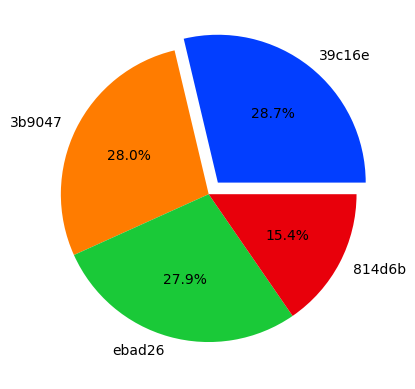

In [41]:
# Lets plot a pie of texts with different catagories of prompts

# explode offset for biggest slice
explode = (0.1, 0, 0, 0)
# define Seaborn color palette to use
palette_color = sns.color_palette('bright')
# plotting data on chart
plt.pie(df_train_summ['prompt_id'].value_counts(), labels=df_train_summ['prompt_id'].value_counts().index, colors=palette_color, autopct='%1.1f%%', explode=explode)

With Profiling Report and a pie chart we can see that the most used propt_id is 39c16e. Lets have a deep look at the values in the text using this prompt.

In [19]:
text = ' '.join(df_train_summ[df_train_summ['prompt_id']=='39c16e'].text.values)

In [20]:
text

'1 element of an ideal tragedy is that it should be arranged on a complex plan.  Another element of an ideal tragedy is that it should only have one main issue. The last element of an ideal tragedy is that it should have a double thread plot and an opposite catastrophe for both good and bad. The three elements of an ideal tragedy are:  Having a character that isn\'t bad have misfortune befall them.,  Having no subplots, and ending in death.   Aristotle states that an ideal tragedy should have a "complex plan" (a well-thought-out plot), "imitate actions which excite pity and fear" (present ideas that might evoke certain emotions from the audience), and should only have a "single... issue", with the "change of fortune" being from "good to bad" (or a character\'s downfall).  One element of an Ideal tragedy is having a complex plan that imitates action that excite pity and fear to result in shock for the audience. Another element is that an ideal tragedy should be relatable to the audience

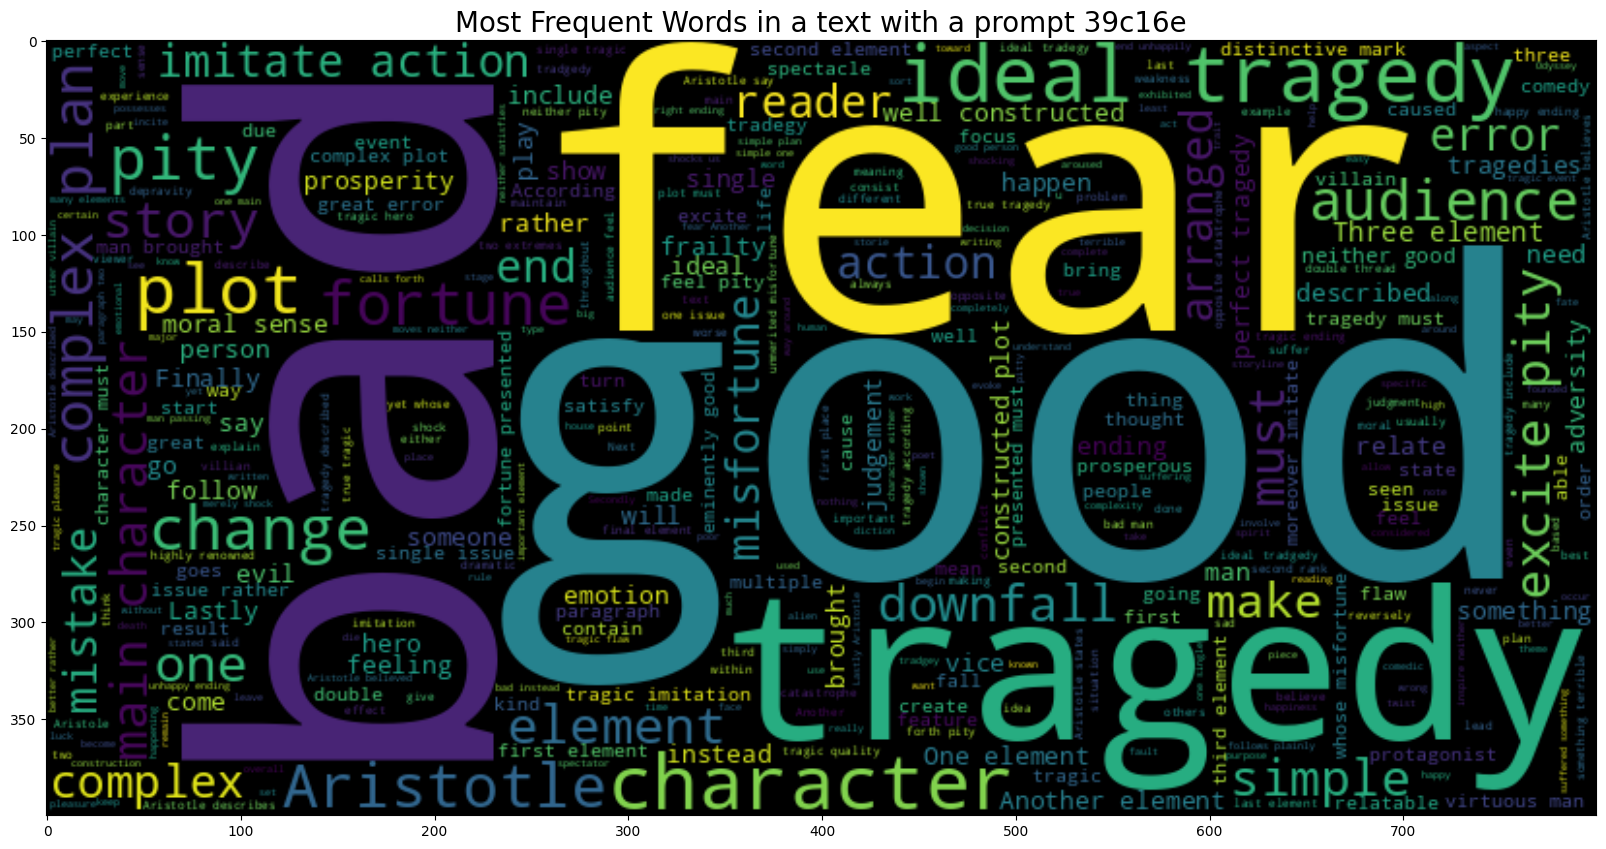

In [21]:
plt.figure(figsize = (20,20))
plt.title("Most Frequent Words in a text with a prompt 39c16e", fontsize = 20)
wc = WordCloud(max_words = 500 , width = 800 , height = 400).generate(text)
plt.imshow(wc, interpolation = 'bilinear')


## Feature engineering

First we need to remove the stopwords from the text

In [22]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [23]:
#Column for the total number of words
df_train_summ["word_count"]=df_train_summ.apply(lambda x: len(x["text"].split(' ')),axis=1)
stopwords=nltk.corpus.stopwords
stopwords=stopwords.words('english')

First 10 stopwords

In [29]:
stopwords[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [25]:
print("Text: ",df_train_summ.text[1234])
print("Number of words: ",df_train_summ["word_count"][1234])

Text:  they used chemicals to remove the smell of the spoiled meats they also used heat to heat up the insides of the meats to make them not smell anymore and to give the apearence that they are fresh meats.
Number of words:  39


<Axes: xlabel='word_count', ylabel='Count'>

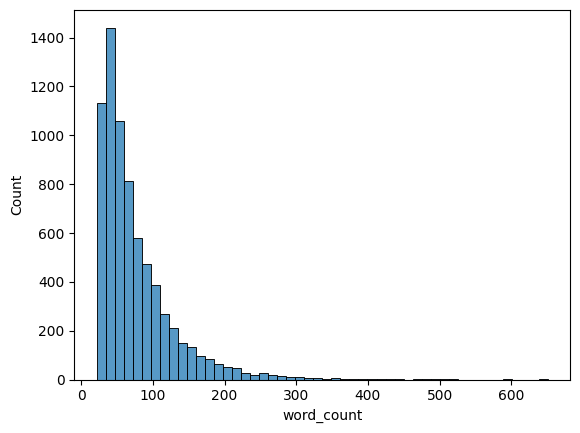

In [44]:
sns.histplot(df_train_summ["word_count"], bins=50)

Text(0.5, 1.0, 'correlation between word count and wording score')

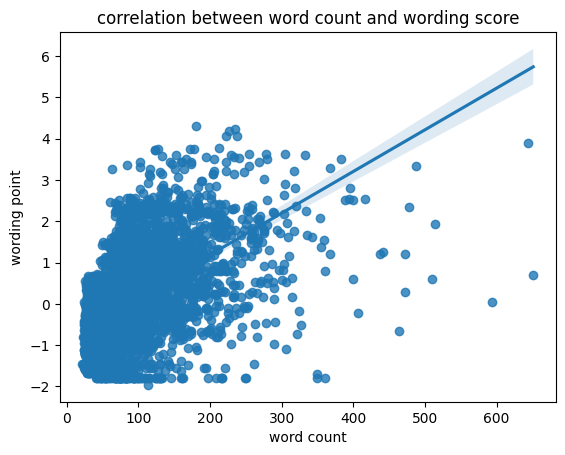

In [51]:
sns.regplot(data=df_train_summ,x="word_count",y="wording", truncate=True)
plt.xlabel("word count")
plt.ylabel("wording point")
plt.title("correlation between word count and wording score")

Text(0.5, 1.0, 'correlation between word count and content score')

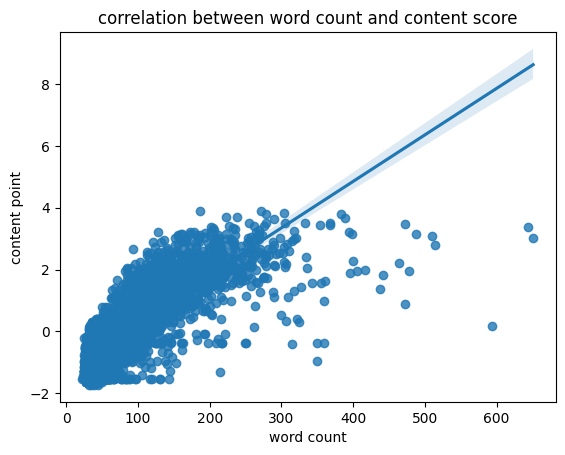

In [50]:
sns.regplot(data=df_train_summ,x="word_count",y="content", truncate=True)
plt.xlabel("word count")
plt.ylabel("content point")
plt.title("correlation between word count and content score")

In [55]:
# Let's do a text transformation

# Convert the text in the "text" column of your DataFrame to lowercase.
df_train_summ["transformed_text"]=df_train_summ.text.str.lower()
# Finally, use the re.sub() function to replace any non-alphanumeric characters with a space.
df_train_summ["transformed_text"]=df_train_summ["transformed_text"].apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x))

Now, in transformed_text column we have the text in lowercase and without any non-alphanumeric characters (punctuations, other special characters)

In [58]:
print("Transformed Text: ",df_train_summ["transformed_text"][0])

Transformed Text:  the third wave was an experimentto see how people reacted to a new one leader government  it gained popularity as people wanted to try new things  the students follow anything that is said and start turning on eachother to gain higher power  they had to stop the experement as too many people got to radical with it blindly following there leader
